<a href="https://colab.research.google.com/github/hf2000510/infectious_disease_modelling/blob/master/part_three.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure to open in colab to see the plots!


You might want to change the plot sizes; just ctrl+f for "figsize" and change them all (ex.: (20,4) to (10,2))

# Imports

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

from scipy.integrate import odeint
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

import warnings
warnings.filterwarnings('ignore')

# Curve Fitting Example

We want to fit the following curve:

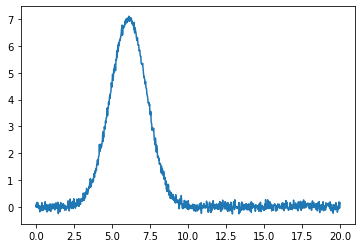

In [2]:
np.random.seed(42)
x = np.linspace(0, 20.0, 1001)

data = (gaussian(x, 21, 6.1, 1.2) + np.random.normal(scale=0.1, size=x.size))  # normal distr. with some noise
plt.plot(x, data);

So we define a function that takes x as the first argument, and then the parameters to be fitted (a, b, c)

In [3]:
def f(x, a, b, c):
    return gaussian(x, a, b, c) 

In [4]:
mod = lmfit.Model(f)
# we set the parameters (and some initial parameter guesses)
mod.set_param_hint("a", value=10.0, vary=True)
mod.set_param_hint("b", value=10.0, vary=True)
mod.set_param_hint("c", value=10.0, vary=True)

params = mod.make_params()

In [5]:
result = mod.fit(data, params, method="leastsq", x=x)  # fitting

{'a': 21.032607053235708, 'b': 6.100343154233262, 'c': 1.2009255088627309}

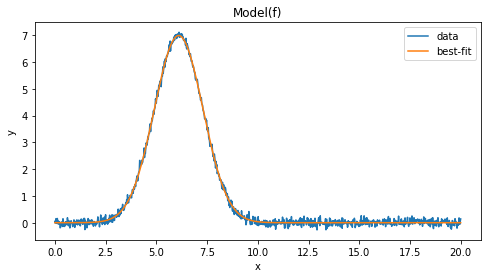

In [6]:
plt.figure(figsize=(8,4))
result.plot_fit(datafmt="-");
result.best_values

In [7]:
result

# Supplemental and Coronavirus Data

In [33]:
# !! if you get a timeout-error, just click on the link and download the data manually !!

# read the data
#beds = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")
covid_data = pd.read_csv("time_series_covid19_confirmed_global_narrow.csv", parse_dates=["Date"], skiprows=[1])
covid_data["Location"] = covid_data["Country/Region"]

# create some dicts for fast lookup
# 1. beds
#beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
# 2. agegroups
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))

# store the probabilities collected
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

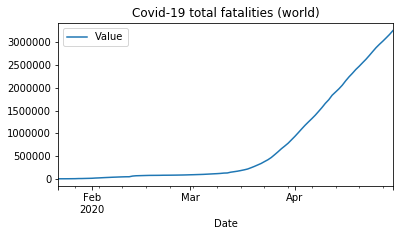

In [34]:
covid_data.groupby("Date").sum()[["Value"]].plot(figsize=(6, 3), title="Covid-19 total fatalities (world)");

## Plotting

In [210]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
        print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")


    f, ax = plt.subplots(1,1,figsize=(10,2))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(10,2))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        #ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        #ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

<Figure size 432x288 with 0 Axes>

# Model

In [211]:
def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * C - max(0, C) - (1 - p_C_to_D) * 1/6.5 * C
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * C
    dDdt = 1/7.5 * p_C_to_D * C + C
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [212]:
gamma = 1.0/9.0
sigma = 1.0/3.0

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    N = sum(agegroups)

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days, dtype=int)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, C, R, D, R_0_over_time, prob_I_to_C, prob_C_to_D

In [213]:
agegroups = agegroup_lookup["France"]

In [214]:
#best params 
{'R_0_start': 3.227520776740839,
 'k': 0.16421413903494697,
 'x0': 97.76841467723465,
 'R_0_end': 1.4898550403139865e-09,
 'prob_I_to_C': 0.18294309050255445,
 'prob_C_to_D': 0.6103959798330199}


{'R_0_start': 3.227520776740839,
 'k': 0.16421413903494697,
 'x0': 97.76841467723465,
 'R_0_end': 1.4898550403139865e-09,
 'prob_I_to_C': 0.18294309050255445,
 'prob_C_to_D': 0.6103959798330199}

In [215]:
Model(days=500, agegroups=agegroups, 
               R_0_start=3.227520776740839, k=0.16421413903494697, x0=97.76841467723465, R_0_end=1.4898550403139865e-09, 
               prob_I_to_C=0.18294309050255445, prob_C_to_D=0.6103959798330199)[3]

array([ 0.00000000e+00,  2.73538043e-01,  4.68586858e-01,  6.26436235e-01,
        7.71142925e-01,  9.17308482e-01,  1.07444292e+00,  1.24942756e+00,
        1.44792177e+00,  1.67518574e+00,  1.93658335e+00,  2.23791331e+00,
        2.58565241e+00,  2.98715881e+00,  3.45086352e+00,  3.98646744e+00,
        4.60515536e+00,  5.31983586e+00,  6.14541399e+00,  7.09910413e+00,
        8.20078985e+00,  9.47343924e+00,  1.09435840e+01,  1.26418726e+01,
        1.46037094e+01,  1.68699926e+01,  1.94879667e+01,  2.25122076e+01,
        2.60057599e+01,  3.00414507e+01,  3.47034079e+01,  4.00888129e+01,
        4.63099261e+01,  5.34964262e+01,  6.17981115e+01,  7.13880218e+01,
        8.24660411e+01,  9.52630631e+01,  1.10045798e+02,  1.27122324e+02,
        1.46848504e+02,  1.69635387e+02,  1.95957762e+02,  2.26364028e+02,
        2.61487596e+02,  3.02060047e+02,  3.48926318e+02,  4.03062235e+02,
        4.65594740e+02,  5.37825227e+02,  6.21256457e+02,  7.17623576e+02,
        8.28929945e+02,  

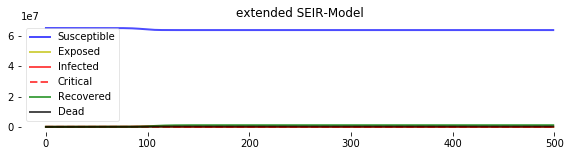

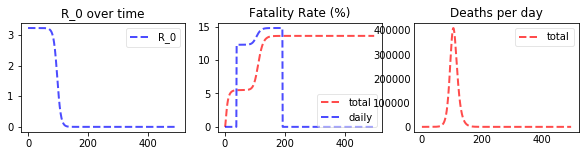

In [216]:
plotter(*Model(days=500, agegroups=agegroups, 
               R_0_start=3.227520776740839, k=0.16421413903494697, x0=97.76841467723465, R_0_end=1.4898550403139865e-09, 
               prob_I_to_C=0.18294309050255445, prob_C_to_D=0.6103959798330199))

# Fitting

In [174]:
# parameters
data = covid_data[(covid_data["Location"] == "France") & (covid_data['Province/State'].isnull())]["Value"].values[::-1]
agegroups = agegroup_lookup["France"]
beds_per_100k = beds_lookup["France"]
outbreak_shift = 30
params_init_min_max = {"R_0_start": (3.0, 0.5, 9), "k": (2.5, 0.01, 8.0), "x0": (32, 0, 300), "R_0_end": (3.0, 0.00000000003, 9),
                       "prob_I_to_C": (0.05, 0.01, 5), "prob_C_to_D": (0.5, 0.01, 4)}  # form: {parameter: (initial guess, minimum value, max value)}

In [175]:
days = outbreak_shift + len(data)

if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D):
    ret = Model(days, agegroups, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D)
    return ret[6][x]

In [176]:
y_data

array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 2.00000e+00, 3.00000e+00, 3.00000e+00,
       3.00000e+00, 4.00000e+00, 5.00000e+00, 5.00000e+00, 5.00000e+00,
       6.00000e+00, 6.00000e+00, 6.00000e+00, 6.00000e+00, 6.00000e+00,
       6.00000e+00, 6.00000e+00, 1.10000e+01, 1.10000e+01, 1.10000e+01,
       1.10000e+01, 1.10000e+01, 1.10000e+01, 1.10000e+01, 1.20000e+01,
       1.20000e+01, 1.20000e+01, 1.20000e+01, 1.20000e+01, 1.20000e+01,
       1.20000e+01, 1.20000e+01, 1.20000e+01, 1.20000e+01, 1.40000e+01,
       1.80000e+01, 3.80000e+01, 5.70000e+01, 1.00000e+02, 1.300

In [177]:
# def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
#     ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
#     return ret[6][x]

In [178]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [179]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)

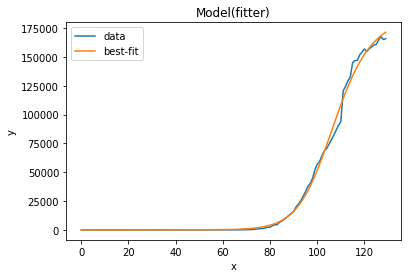

In [180]:
result.plot_fit(datafmt="-")

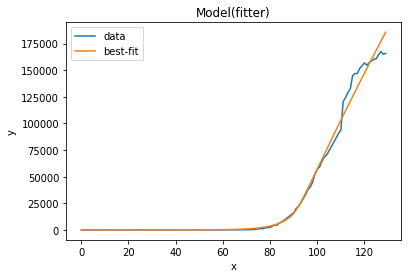

In [32]:
result.plot_fit(datafmt="-")

In [98]:
result.best_fit

array([0.00000000e+00, 4.23171778e-03, 2.47972208e-02, 6.41880653e-02,
       1.21559937e-01, 1.96599276e-01, 2.90193350e-01, 4.04362393e-01,
       5.42114011e-01, 7.07363835e-01, 9.04932634e-01, 1.14060431e+00,
       1.42123031e+00, 1.75487143e+00, 2.15097271e+00, 2.62057029e+00,
       3.17653109e+00, 3.83382801e+00, 4.60985305e+00, 5.52477304e+00,
       6.60193181e+00, 7.86830398e+00, 9.35500539e+00, 1.10978660e+01,
       1.31380714e+01, 1.55228787e+01, 1.83064145e+01, 2.15505613e+01,
       2.53259395e+01, 2.97129929e+01, 3.48031845e+01, 4.07003123e+01,
       4.75219496e+01, 5.54010200e+01, 6.44875093e+01, 7.49503394e+01,
       8.69793749e+01, 1.00787608e+02, 1.16613497e+02, 1.34723484e+02,
       1.55414673e+02, 1.79017690e+02, 2.05899710e+02, 2.36467659e+02,
       2.71171572e+02, 3.10508127e+02, 3.55024307e+02, 4.05321222e+02,
       4.62058033e+02, 5.25955999e+02, 5.97802592e+02, 6.78455664e+02,
       7.68847697e+02, 8.69989959e+02, 9.82976695e+02, 1.10898921e+03,
      

In [279]:
# results = []
results.append(result.best_fit)

In [183]:
final = pd.DataFrame(results)

In [186]:
final

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,0.0,0.000044,0.000308,0.000920,0.001947,0.003422,0.005362,0.007775,0.010665,0.014037,...,238.788119,257.191884,277.013524,298.362247,321.355666,346.120444,372.792996,401.520231,432.460366,465.783788
1,0.0,0.000020,0.000143,0.000434,0.000932,0.001672,0.002682,0.003996,0.005650,0.007689,...,24596.987396,25028.944318,25448.056122,25854.613448,26248.913064,26631.255635,27001.943857,27361.280866,27709.568904,28047.108205
2,0.0,0.000004,0.000031,0.000095,0.000206,0.000372,0.000604,0.000910,0.001303,0.001797,...,16221.455822,17818.877261,19557.374277,21906.189520,24956.052226,28450.377713,32301.764336,36483.451196,40989.481539,45819.950487


In [215]:
final.to_csv('ThreeScenariosItaly_rows.csv')

In [188]:
result.best_values

{'R_0_start': 3.227520776740839,
 'k': 0.16421413903494697,
 'x0': 97.76841467723465,
 'R_0_end': 1.4898550403139865e-09,
 'prob_I_to_C': 0.18294309050255445,
 'prob_C_to_D': 0.6103959798330199}

Prediction for Italy
percentage going to ICU: 6.882630197999043; percentage dying in ICU: 53.711087506655566


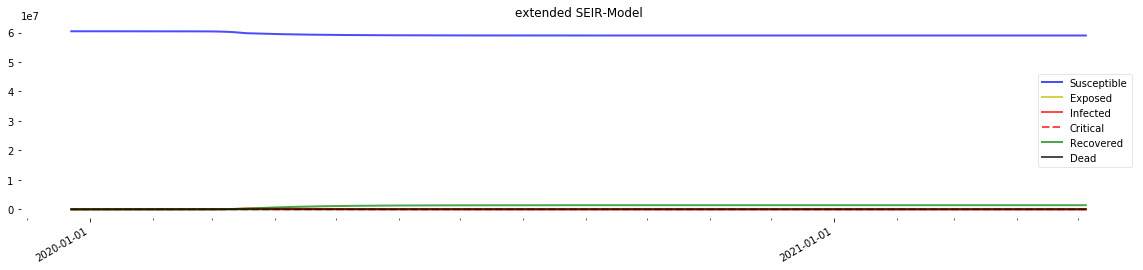

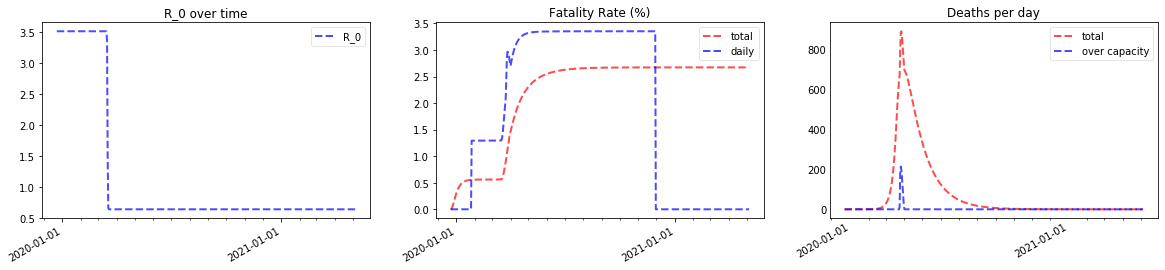

In [41]:
full_days = 500
first_date = np.datetime64(covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for Italy")
plotter(*Model(full_days, agegroup_lookup["Italy"], beds_lookup["Italy"], **result.best_values), x_ticks=x_ticks);